In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score
from typing import Any, Union, Callable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [6]:
df = pd.read_csv('../data/dataset.csv')

In [7]:
print(df.shape) # prints the dimensions of the DataFrame

missing_values = np.where(df.isnull(), 1, 0).sum()
print("\nMissing Values:\n", missing_values)

(35001, 32)

Missing Values:
 23616


In [8]:
df.head()

,user_id,age,education,gender,name,country,music,artist_name,featured_artists,genre,...,valence,tempo,time_signature,track_genre,release_date,explicit,duration,music_id,id_artists,followers
0,83811,16,Undergraduate,Male,Danielle,Urban,Bank Account,21 Savage,"Birdy, Zoé",Dark Trap,...,0.198838,147.482666,5,Unknown,2017-09-23,True,3.67,2fQrGHiQOvpL9UgPvtYy6G,spotify:artist:1URnnhqYAYcrqrcwql10ft,440898
1,83811,16,Undergraduate,Male,Danielle,Urban,Mo Money Mo Problems (feat. Mase & Puff Daddy)...,The Notorious B.I.G.,LUDMILLA,Underground Rap,...,0.904000,104.536000,4,hardcore,1997-03-04,False,4.29,4INDiWSKvqSKDEu7mh8HFz,spotify:artist:5me0Irg2ANcsgc93uaYrpb,849749
2,83811,16,Undergraduate,Male,Danielle,Urban,Little Talks,Of Monsters and Men,"Ninho, Snoop Dogg, Russ, Paramore",NaN,...,0.417000,102.961000,4,folk,2012-01-01,True,4.44,2ihCaVdNZmnHZWt0fvAM7B,spotify:artist:4dwdTW1Lfiq0cM8nBAqIIz,733052
3,13397,17,Middle School,Female,Angel,Non-Urban,Wherever I Go,OneRepublic,"Keith Urban, DJ Khaled, NIKI, MF DOOM",NaN,...,0.349000,99.961000,4,piano,2016-12-02,True,2.83,46jLy47W8rkf8rEX04gMKB,spotify:artist:5Pwc4xIPtQLFEnJriah9YJ,766179
4,13397,17,Middle School,Female,Angel,Non-Urban,Hands To Myself,Selena Gomez,"SAINt JHN, David Bisbal, will.i.am",NaN,...,0.079792,84.918633,3,Unknown,2015-10-09,True,3.34,3CJvmtWw2bJsudbAC5uCQk,spotify:artist:0C8ZW7ezQVs4URX5aX7Kqx,399591


In [9]:
# Remove rows containing missing values
df_clean = df.dropna()

# prints the dimensions of the cleaned DataFrame
df_clean.shape


(14025, 32)

In [10]:
# df = pd.read_csv('../data/cleaned_data.csv')
df = df_clean

In [11]:
duplicate_records = df.duplicated().sum()
print(duplicate_records)


0


In [12]:
df.shape

(14025, 32)

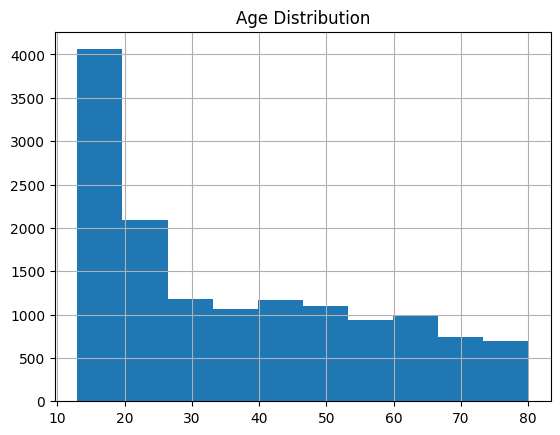

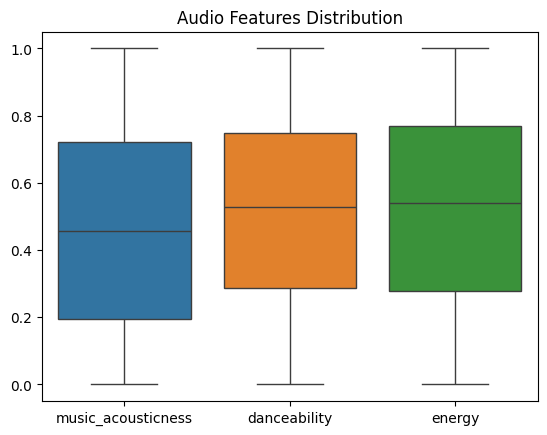

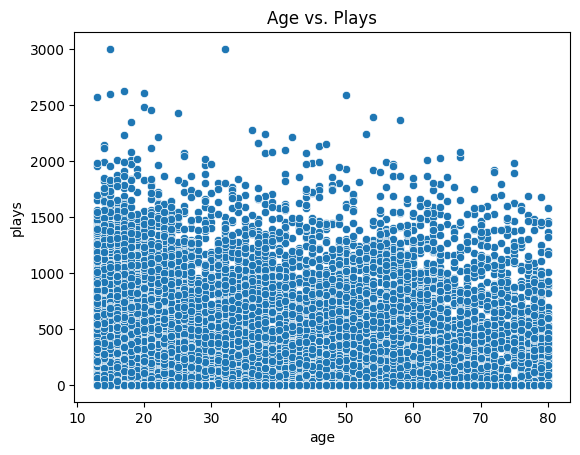

In [13]:
# Summary statistics
summary_stats = df.describe()

# Histograms
df['age'].hist()
plt.title('Age Distribution')
plt.show()

# Box plots for audio features
sns.boxplot(data=df[['music_acousticness', 'danceability', 'energy']])
plt.title('Audio Features Distribution')
plt.show()

# Scatter plots for correlations
sns.scatterplot(x='age', y='plays', data=df)
plt.title('Age vs. Plays')
plt.show()


In [14]:
# AGE GROUPING
# Example: Age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 25, 40, 60, 100], labels=['Teenager', 'Young Adult', 'Adult', 'Mature Adult', 'Elderly'])

df['age_group'].unique()

['Teenager', 'Mature Adult', 'Adult', 'Elderly', 'Young Adult']
Categories (5, object): ['Teenager' < 'Young Adult' < 'Adult' < 'Mature Adult' < 'Elderly']

Average Plays per User


In [15]:
df['avg_plays_per_user'] = df.groupby('user_id')['plays'].transform('mean')
# df['avg_plays_per_user'].unique()

Aggregrate Popularity Metrics by User Demographics


In [16]:
df['avg_artiste_popularity'] = df.groupby(['age_group', 'gender'])['artiste_popularity'].transform('mean')
df['avg_audio_popularity'] = df.groupby(['age_group', 'gender'])['audio_popularity'].transform('mean')


Summary Statistics for Audio Features by User


In [17]:
audio_features = ['music_acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo']
for feature in audio_features:
    df[f'avg_{feature}_by_demo'] = df.groupby(['age_group', 'gender'])[feature].transform('mean')


Temporal Features:
Extracting Year, Month and Day from Release Date


In [18]:
df['release_year'] = pd.to_datetime(df['release_date']).dt.year
df['release_month'] = pd.to_datetime(df['release_date']).dt.month
df['release_day'] = pd.to_datetime(df['release_date']).dt.day


Calculate Song's Age Since Release:


In [19]:
current_year = pd.to_datetime('today').year
df['song_age'] = current_year - df['release_year']


User Preferences:


In [20]:
user_profiles = df.groupby('user_id')['genre'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
df['user_favorite_genre'] = df['user_id'].map(user_profiles)


Calculate Diversity of Genres Each User Listens To:


In [21]:
df['user_genre_diversity'] = df.groupby('user_id')['genre'].transform(lambda x: x.nunique())

Interaction Features:
Capture Interactions Between User Demographics and Song Characteristics:


In [22]:
df['age_genre_interaction'] = df['age'] * df['genre'].apply(lambda x: hash(x) % 100)


Create Features that Measure User Affinity Towards Certain Genres or Artists:


In [23]:
df = df.dropna(subset=['user_id', 'genre'])

user_genre_affinity = df.groupby(['user_id', 'genre'])['plays'].sum().unstack().fillna(0)
df['user_genre_affinity'] = df.apply(lambda row: user_genre_affinity.loc[row['user_id'], row['genre']], axis=1)

Advanced Audio Features:
Create Composite Features from Existing Audio Features:


In [24]:
df['energy_acousticness_ratio'] = df['energy'] / (df['music_acousticness'] + 1e-9)


In [25]:
# Adding a feature for season based on release month
df['release_season'] = df['release_month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')


### **Feature Selection**


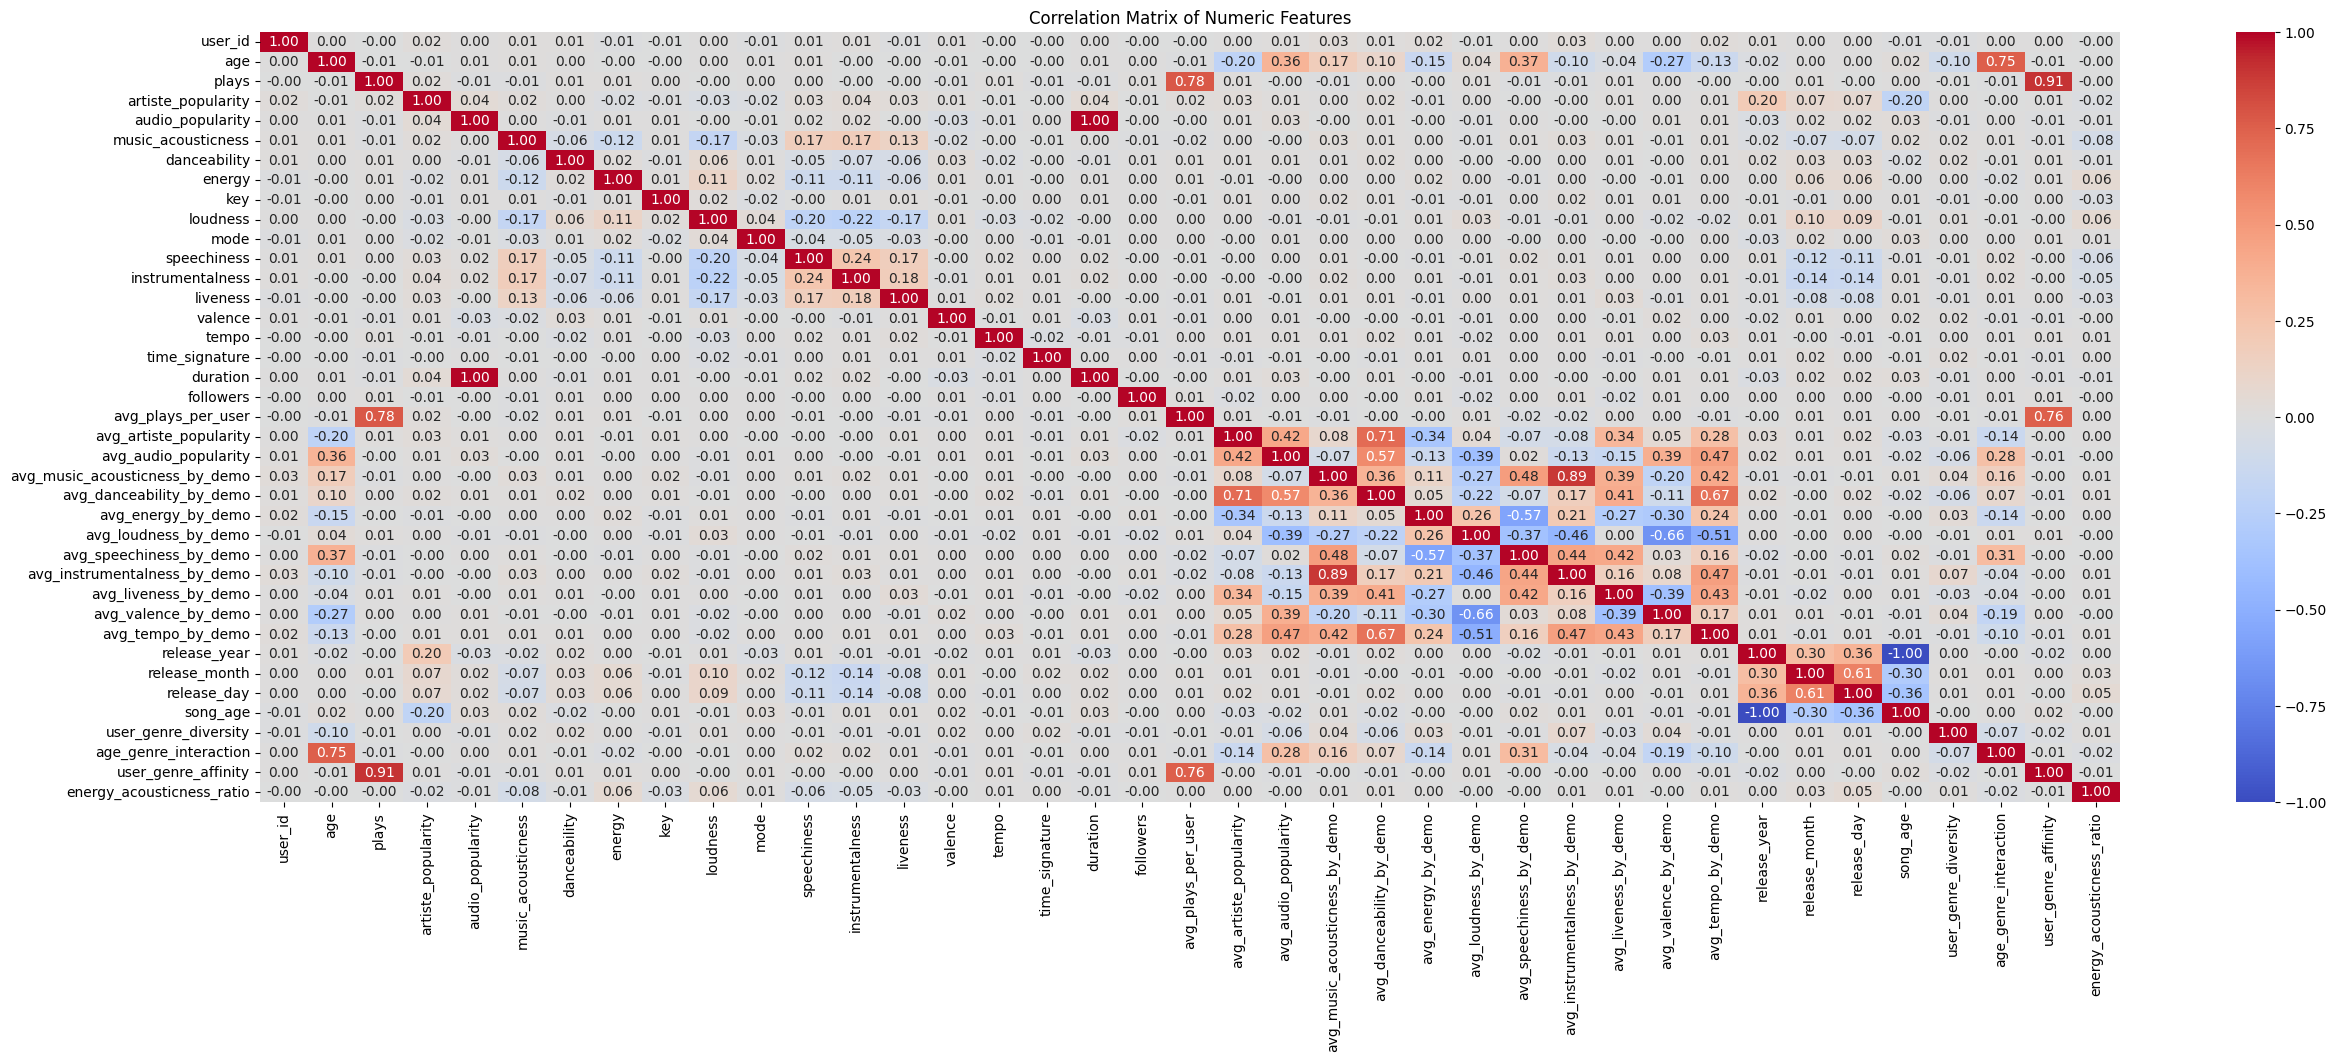

In [26]:
# Assuming df is already loaded and preprocessed
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
correlation_matrix = df[numeric_features].corr()

# Plot the heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [27]:
# df.head()

In [28]:
# Drop unnecessary columns
# df.drop(columns=['Unnamed: 0'], inplace=True)

In [29]:
df.columns

Index(['user_id', 'age', 'education', 'gender', 'name', 'country', 'music',
       'artist_name', 'featured_artists', 'genre', 'plays',
       'artiste_popularity', 'audio_popularity', 'music_acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'release_date', 'explicit', 'duration', 'music_id',
       'id_artists', 'followers', 'age_group', 'avg_plays_per_user',
       'avg_artiste_popularity', 'avg_audio_popularity',
       'avg_music_acousticness_by_demo', 'avg_danceability_by_demo',
       'avg_energy_by_demo', 'avg_loudness_by_demo', 'avg_speechiness_by_demo',
       'avg_instrumentalness_by_demo', 'avg_liveness_by_demo',
       'avg_valence_by_demo', 'avg_tempo_by_demo', 'release_year',
       'release_month', 'release_day', 'song_age', 'user_favorite_genre',
       'user_genre_diversity', 'age_genre_interaction', 'user_genre_affinity',
       'e

In [30]:


# Identify features
categorical_features = ['education', 'gender', 'country', 'age_group', 'user_favorite_genre']
numerical_features = df.select_dtypes(include=[float, int]).columns.tolist()

# Remove the target variable from numerical features
numerical_features.remove('plays')  # Assuming 'plays' is the target variable

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the target variable
X = df.drop(columns=['plays'])
y = df['plays']

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Checking the shape of the preprocessed data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (11220, 86)
Shape of X_test: (2805, 86)
Shape of y_train: (11220,)
Shape of y_test: (2805,)


Top 10 Important features
Feature ranking:
37. feature 36 (0.8495105743729546)
19. feature 18 (0.04564407918637321)
35. feature 34 (0.020793125246571682)
14. feature 13 (0.005013296992677171)
11. feature 10 (0.004512448162024569)
13. feature 12 (0.004364717041730003)
38. feature 37 (0.0043629036548540135)
18. feature 17 (0.004300923451516608)
15. feature 14 (0.004262416477758469)
7. feature 6 (0.004176679532956135)
Selected Features:
Int64Index([36, 18, 34, 13, 10, 12, 37, 17, 14, 6], dtype='int64')


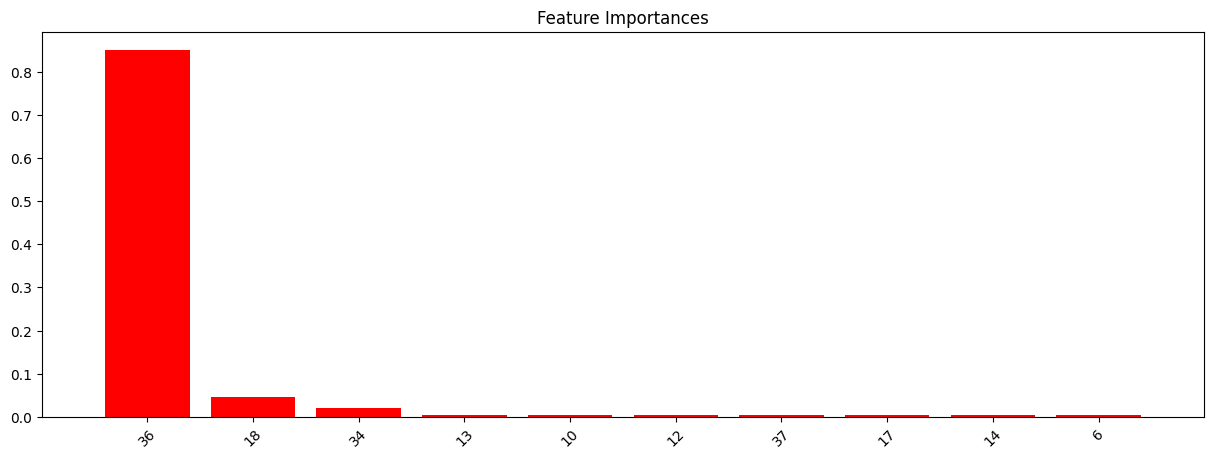

In [31]:
# Keep a copy of the DataFrame for later use
X_train_df = pd.DataFrame(X_train)  # Convert numpy array back to DataFrame if needed

# Fit a RandomForestRegressor to analyze feature importance
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Get the top 10 features
print('Top 10 Important features')
top_10_features = indices[:10]

# Print the feature ranking
print("Feature ranking:")
for f in top_10_features:
    print(f"{f + 1}. feature {X_train_df.columns[f]} ({importances[f]})")

# Use the original DataFrame to get the feature names
selected_features = X_train_df.columns[top_10_features]
print("Selected Features:")
print(selected_features)

# Plot the feature importances
plt.figure(figsize=(15, 5))
plt.title("Feature Importances")
plt.bar(range(10), importances[top_10_features], color="r", align="center")
# Use feature names as x-ticks
plt.xticks(range(10), selected_features, rotation=45)
plt.xlim([-1, 10])
plt.show()


In [32]:
# get me the printed array of items indexed by these from the dataframe 

selected_columns = df.columns[selected_features]

# Print the names of the selected columns
print(selected_columns)


Index(['avg_music_acousticness_by_demo', 'mode', 'avg_artiste_popularity',
       'music_acousticness', 'plays', 'audio_popularity',
       'avg_danceability_by_demo', 'loudness', 'danceability', 'music'],
      dtype='object')


In [33]:
df.shape

(14025, 55)

In [34]:
# import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def identify_multicollinearity(df, numerical_features, corr_threshold=0.7, vif_threshold=10):
    """
    Identify multicollinearity in the dataset by calculating the correlation matrix
    and Variance Inflation Factor (VIF).

    Parameters:
    df (DataFrame): The input DataFrame with numerical features.
    numerical_features (list): List of numerical feature names in the DataFrame.
    corr_threshold (float): The threshold for identifying high correlation.
    vif_threshold (float): The threshold for identifying high VIF.

    Returns:
    tuple: A tuple containing sets of highly correlated features and high VIF features.
    """

    # Task 1: Identify Multicollinearity
    correlation_matrix = df[numerical_features].corr()
    highly_correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Task 2: Implement VIF
    vif_data = df[numerical_features]
    vif = pd.DataFrame()
    vif["Features"] = vif_data.columns
    vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    high_vif_features = vif[vif["VIF"] > vif_threshold]["Features"]

    return highly_correlated_features, high_vif_features

# Example usage:
# Assuming 'df' is your DataFrame and 'numerical_features' is your list of numerical feature names
correlated_features, high_vif_features = identify_multicollinearity(df, numerical_features)
print("Highly correlated features:", correlated_features)
print("Features with high VIF (>10):", high_vif_features)


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Highly correlated features: {'avg_instrumentalness_by_demo', 'user_genre_affinity', 'song_age', 'duration', 'avg_danceability_by_demo', 'age_genre_interaction'}
Features with high VIF (>10): 1                                age
3                   audio_popularity
16                          duration
19            avg_artiste_popularity
20              avg_audio_popularity
21    avg_music_acousticness_by_demo
22          avg_danceability_by_demo
23                avg_energy_by_demo
24              avg_loudness_by_demo
25           avg_speechiness_by_demo
26      avg_instrumentalness_by_demo
27              avg_liveness_by_demo
28               avg_valence_by_demo
29                 avg_tempo_by_demo
30                      release_year
33                          song_age
Name: Features, dtype: object


In [35]:
# List of features to drop based on correlation and VIF
features_to_drop = [
    'avg_audio_popularity',
    'duration', 'avg_loudness_by_demo', 'avg_speechiness_by_demo', 
    'release_year','release_month','avg_music_acousticness_by_demo',
    'avg_danceability_by_demo', 'avg_energy_by_demo','avg_instrumentalness_by_demo',
    'avg_liveness_by_demo', 'avg_valence_by_demo', 'avg_tempo_by_demo', 'release_season'
    
    # Add other highly correlated features identified in the correlation matrix
]
# Dropping the selected features
df_reduced = df.drop(columns=features_to_drop)

# Checking the remaining features
print(df_reduced.columns)


Index(['user_id', 'age', 'education', 'gender', 'name', 'country', 'music',
       'artist_name', 'featured_artists', 'genre', 'plays',
       'artiste_popularity', 'audio_popularity', 'music_acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'release_date', 'explicit', 'music_id', 'id_artists',
       'followers', 'age_group', 'avg_plays_per_user',
       'avg_artiste_popularity', 'release_day', 'song_age',
       'user_favorite_genre', 'user_genre_diversity', 'age_genre_interaction',
       'user_genre_affinity', 'energy_acousticness_ratio'],
      dtype='object')


In [36]:
df_reduced.shape

(14025, 41)

C:\Users\jnopa\AppData\Local\Temp\ipykernel_18608\3307894794.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_reduced.corr()


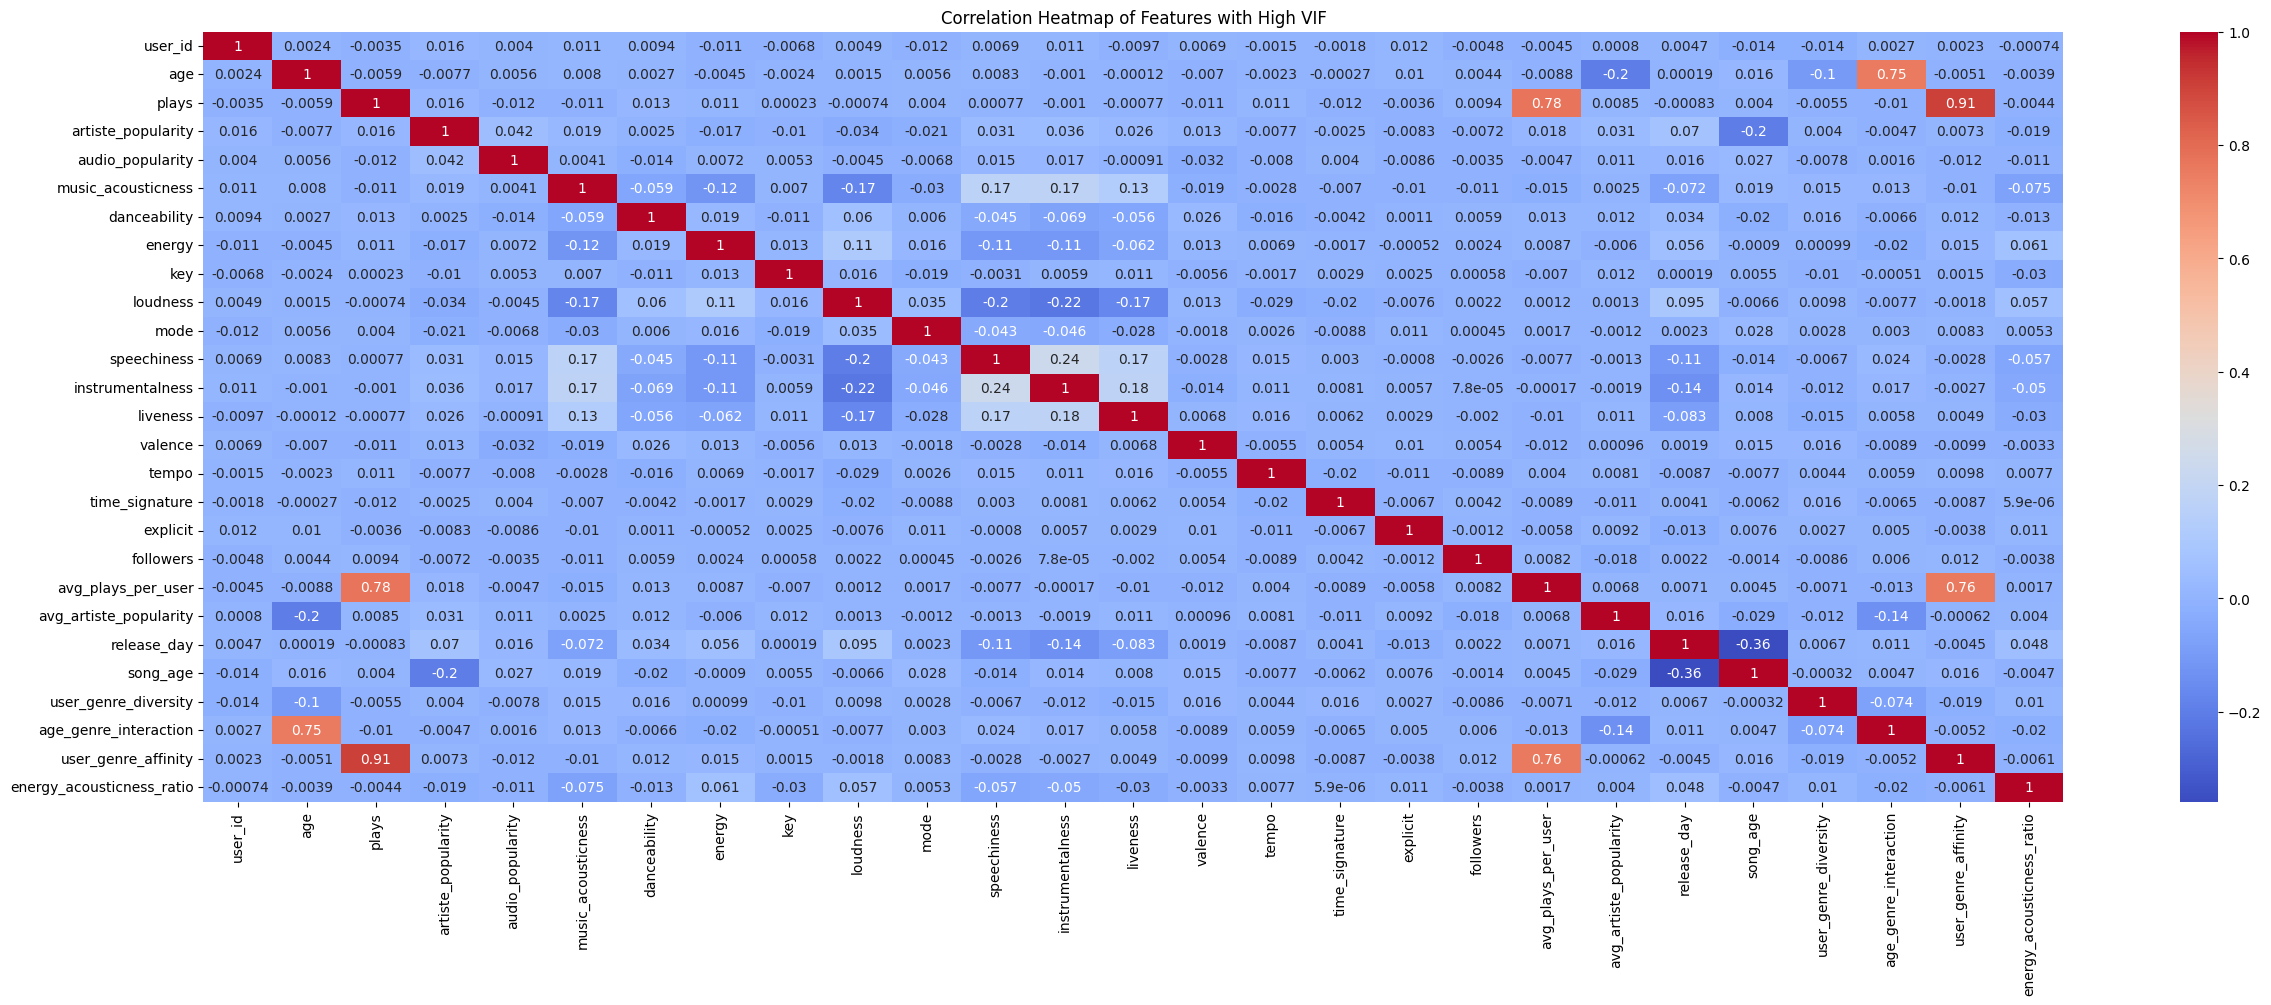

In [37]:
# Create a correlation matrix
corr_matrix = df_reduced.corr()

# Plot the correlation heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features with High VIF')
plt.show()

In [38]:
# df.set_index('user_id', inplace=True)

In [39]:
# Retaining important features
important_features = [
    'user_id','age_group','education','country','music','artist_name',
    'featured_artists', 'avg_plays_per_user', 'song_age', 'user_favorite_genre',
    'user_genre_diversity', 'user_genre_affinity', 'energy_acousticness_ratio'
    # Add any other retained features here after checking their importance
]

df_final = df_reduced[important_features]


In [40]:
df_final

,user_id,age_group,education,country,music,artist_name,featured_artists,avg_plays_per_user,song_age,user_favorite_genre,user_genre_diversity,user_genre_affinity,energy_acousticness_ratio
0,83811,Teenager,Undergraduate,Urban,Bank Account,21 Savage,"Birdy, Zoé",551.000000,7,Dark Trap,2,11.0,0.128475
1,83811,Teenager,Undergraduate,Urban,Mo Money Mo Problems (feat. Mase & Puff Daddy)...,The Notorious B.I.G.,LUDMILLA,551.000000,27,Dark Trap,2,1091.0,69.062495
8,70645,Mature Adult,Graduate,Non-Urban,No New Friends,DJ Khaled,"The xx, LIT killah",230.000000,24,Pop,1,230.0,0.391406
12,10323,Teenager,Graduate,Urban,Love Without Tragedy / Mother Mary,Rihanna,"Brett Young, Blueface, Lana Del Rey, Queens of...",905.000000,24,Hip-Hop,1,905.0,4.366730
14,7945,Mature Adult,Middle School,Urban,Roses,The Chainsmokers,"Jonas Blue, Radiohead, Pearl Jam, ABBA",728.000000,24,Jazz,2,1261.0,0.190409
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34989,10623,Teenager,Graduate,Urban,Brown Eyed Girl,Van Morrison,"Morat, Alanis Morissette, James Bay, Luis Fonsi",706.333333,57,Dance/Electronic,3,1.0,3.151351
34993,74433,Teenager,High School,Urban,Houses Of The Holy,Led Zeppelin,"Dido, Van Halen, Bazzi, Years & Years, Bibi Bl...",890.000000,49,Dance/Electronic,1,890.0,0.280685
34997,94134,Mature Adult,Graduate,Urban,Take You Down,Chris Brown,Florida Georgia Line,176.000000,24,Rock,1,176.0,1.353299
34999,78124,Elderly,Graduate,Non-Urban,Radioactive,Imagine Dragons,"Boyce Avenue, Dermot Kennedy, Kelly Rowland",1.000000,24,Christian/Gospel,2,1.0,0.916113


In [41]:
df = df_final

In [42]:

# Select relevant features
subset_features = [
    'user_id',  # Keep the user_id for identification
    'age_group', 
    'education', 
    'country', 
    'music', 
    'artist_name', 
    'featured_artists', 
    'avg_plays_per_user', 
    'song_age', 
    'user_favorite_genre', 
    'user_genre_diversity', 
    'user_genre_affinity', 
    'energy_acousticness_ratio'
]

# Create a new DataFrame with the selected features
df_subset = df[subset_features]

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14025 entries, 0 to 35000
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   user_id                    14025 non-null  int64   
 1   age_group                  14025 non-null  category
 2   education                  14025 non-null  object  
 3   country                    14025 non-null  object  
 4   music                      14025 non-null  object  
 5   artist_name                14025 non-null  object  
 6   featured_artists           14025 non-null  object  
 7   avg_plays_per_user         14025 non-null  float64 
 8   song_age                   14025 non-null  int64   
 9   user_favorite_genre        14025 non-null  object  
 10  user_genre_diversity       14025 non-null  int64   
 11  user_genre_affinity        14025 non-null  float64 
 12  energy_acousticness_ratio  14025 non-null  float64 
dtypes: category(1), float64(3), int

In [44]:
# Further preprocessing

# Define preprocessing for numeric features
numeric_features = [
    'avg_plays_per_user', 
    'song_age', 
    'user_genre_diversity', 
    'user_genre_affinity', 
    'energy_acousticness_ratio'
]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_features = ['age_group', 'education', 'country', 'user_favorite_genre']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessing for text features
text_features = ['artist_name', 'featured_artists']
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=500)),
    ('svd', TruncatedSVD(n_components=50))  # Reducing dimensions
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('artist_tfidf', text_transformer, 'artist_name'),
        ('featured_artists_tfidf', text_transformer, 'featured_artists')
    ])


In [45]:
# Apply preprocessing to the features
df_subset = df_subset.fillna('')

# Apply preprocessing to the features
X = preprocessor.fit_transform(df_subset)


In [46]:
X.shape

(14025, 151)

In [47]:
# Encode the target variable 'music'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_subset['music'])


In [48]:
df.columns

Index(['user_id', 'age_group', 'education', 'country', 'music', 'artist_name',
       'featured_artists', 'avg_plays_per_user', 'song_age',
       'user_favorite_genre', 'user_genre_diversity', 'user_genre_affinity',
       'energy_acousticness_ratio'],
      dtype='object')

In [49]:
# # Split the data into training and test setsa
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)


# # Define the parameter grid to search
# param_dist = {
#     'n_estimators': [500,1000,1500,2000],
#     'max_depth': sp_randint(3, 20),
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': sp_randint(2, 11),
#     'min_samples_leaf': sp_randint(2, 11),
#     'bootstrap': [True, False],
#     'criterion': ['absolute_error', 'squared_error']
# }

# # Initialize the RandomizedSearchCV object
# random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5,verbose=2, random_state=42)

# # Fit the model to the data
# random_search.fit(X_train, y_train)

# # Print the best parameters and the corresponding score
# print(f"Best Parameters: {random_search.best_params_}")
# print(f"Best Score: {random_search.best_score_}")

# # Predict using the best estimator
# y_pred = random_search.best_estimator_.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy with Hyperparameter Tuning: {accuracy}')

# # Convert predicted labels back to original music titles
# y_pred_labels = label_encoder.inverse_transform(y_pred)

# # Display a few predictions
# print("Sample Predictions with Hyperparameter Tuning:")
# for i in range(10):
#     print(f"Predicted: {y_pred_labels[i]}, Actual: {label_encoder.inverse_transform([y_test[i]])[0]}")

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming X is the preprocessed feature matrix
cosine_sim = cosine_similarity(X)

# Function to get recommendations based on content similarity
def get_content_based_recommendations(user_idx, top_n=10):
    sim_scores = list(enumerate(cosine_sim[user_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Exclude the user itself
    item_indices = [i[0] for i in sim_scores]
    return df_subset['music'].iloc[item_indices]

Numbers on the left are the `userids`


In [57]:
user_idx = 28  # Replace with actual user index
content_based_recs = get_content_based_recommendations(user_idx)
print(content_based_recs)

1518                                   Cool for the Summer
10792                                 What's My Age Again?
11265                                             Paranoid
17248    Broken Vessels (Amazing Grace) - Alternate Ver...
6558                                                  Turf
13312                                        All Things Go
10790                     Don't Let Me Down - Zomboy Remix
11263                                                 CRZY
11264                                        Nothing Wrong
1180                                                 Strip
Name: music, dtype: object


Collaborative Filtering


In [58]:
df.columns

Index(['user_id', 'age_group', 'education', 'country', 'music', 'artist_name',
       'featured_artists', 'avg_plays_per_user', 'song_age',
       'user_favorite_genre', 'user_genre_diversity', 'user_genre_affinity',
       'energy_acousticness_ratio'],
      dtype='object')

In [59]:
df.shape

(14025, 13)

In [68]:
# Specify the feature columns

feature_cols = ['user_id','age_group', 'education', 'country', 'artist_name', 'featured_artists','user_favorite_genre', 'avg_plays_per_user', 'song_age', 'user_genre_diversity', 'user_genre_affinity', 'energy_acousticness_ratio']
target_col = 'music'

# Define preprocessing for text features
text_features = ['artist_name', 'featured_artists']
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=500)),
    ('svd', TruncatedSVD(n_components=50))  # Reducing dimensions
])

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['avg_plays_per_user', 'song_age', 'user_genre_diversity', 'user_genre_affinity', 'energy_acousticness_ratio']),
        ('cat', OneHotEncoder(), ['age_group', 'education', 'country', 'user_favorite_genre']),
        ('artist_tfidf',text_transformer, 'artist_name'),
        ('featured_artists_tfidf',text_transformer, 'featured_artists')

    ]
)




# Process the data
X = df[feature_cols]
y = df[target_col]
user_ids = df['user_id']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, train_user_ids, test_user_ids = train_test_split(X, y, user_ids, test_size=0.2, random_state=42)

# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [69]:
X_train_transformed.shape

(11220, 151)

In [70]:
X_test_transformed.shape

(2805, 151)

In [ ]:
df['ratings']

In [76]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import make_scorer

# Define the Nearest Neighbors model
knn = NearestNeighbors(metric='cosine')

# Define a custom scoring function
def custom_scorer(estimator, X):
    labels = estimator.fit(X).labels_
    return silhouette_score(X, labels)

scorer = make_scorer(custom_scorer)

# Hyperparameter tuning using GridSearchCV
param_grid = {'n_neighbors': [5, 10, 15, 20], 'leaf_size': [10, 30, 50]}
random_search = RandomizedSearchCV(knn, param_grid, cv=3, verbose=2, scoring=scorer)
random_search.fit(X_train_transformed)

# Get the best estimator
knn_best = random_search.best_estimator_
print(random_search.best_params_)
print(random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .......................leaf_size=50, n_neighbors=20; total time=   0.0s
[CV] END .......................leaf_size=50, n_neighbors=20; total time=   0.0s
[CV] END .......................leaf_size=50, n_neighbors=20; total time=   0.0s
[CV] END .......................leaf_size=30, n_neighbors=15; total time=   0.0s
[CV] END .......................leaf_size=30, n_neighbors=15; total time=   0.0s
[CV] END .......................leaf_size=30, n_neighbors=15; total time=   0.0s
[CV] END .......................leaf_size=30, n_neighbors=10; total time=   0.0s
[CV] END .......................leaf_size=30, n_neighbors=10; total time=   0.0s
[CV] END .......................leaf_size=30, n_neighbors=10; total time=   0.0s
[CV] END ........................leaf_size=30, n_neighbors=5; total time=   0.0s
[CV] END ........................leaf_size=30, n_neighbors=5; total time=   0.0s
[CV] END ........................leaf_size=30, n

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 969, in _score
    scores = s

[CV] END .......................leaf_size=50, n_neighbors=10; total time=   0.0s
[CV] END .......................leaf_size=50, n_neighbors=10; total time=   0.0s
[CV] END ........................leaf_size=10, n_neighbors=5; total time=   0.0s
[CV] END ........................leaf_size=10, n_neighbors=5; total time=   0.0s
[CV] END ........................leaf_size=10, n_neighbors=5; total time=   0.0s
[CV] END ........................leaf_size=50, n_neighbors=5; total time=   0.0s
[CV] END ........................leaf_size=50, n_neighbors=5; total time=   0.0s
[CV] END ........................leaf_size=50, n_neighbors=5; total time=   0.0s
{'n_neighbors': 20, 'leaf_size': 50}
nan


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 969, in _score
    scores = s

In [75]:
from sklearn.metrics import pairwise_distances

# Loop over all combinations of parameters
for n_neighbors in param_grid['n_neighbors']:
    for leaf_size in param_grid['leaf_size']:
        # Initialize the model with the current parameters
        knn = NearestNeighbors(n_neighbors=n_neighbors, leaf_size=leaf_size, metric='cosine')
        
        # Fit the model
        knn.fit(X_train_transformed)
        
        # Compute a square distance matrix
        distances = pairwise_distances(X_train_transformed)
        
        # Use a DBSCAN clustering on the distance matrix
        dbscan = DBSCAN(min_samples=n_neighbors, metric='precomputed')
        labels = dbscan.fit_predict(distances)
        
        # Check the number of unique labels (clusters)
        if len(set(labels)) < 2:
            continue
        
        # Compute the silhouette score
        score = silhouette_score(X_train_transformed, labels)
        
        # If this score is better than the previous best, update the best score and best parameters
        if score > best_score:
            best_score = score
            best_params = {'n_neighbors': n_neighbors, 'leaf_size': leaf_size}

# Print the best score and best parameters
print('Best score:', best_score)
print('Best parameters:', best_params)

Best score: -0.1987677407143542
Best parameters: {'n_neighbors': 5, 'leaf_size': 10}


The silhouette score ranges from -1 to 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In your case, the silhouette score is negative (-0.1987677407143542), which suggests that the data points might not have been clustered appropriately. It indicates that many data points might not belong to the right cluster.

The best parameters are the parameters that resulted in the highest silhouette score during the grid search. In your case, the best parameters are n_neighbors equal to 5 and leaf_size equal to 10. These are the parameters that, according to your grid search, resulted in the best (highest) silhouette score and thus the most appropriate clustering of your data.

However, given that the silhouette score is negative, you might want to reconsider your clustering approach or the parameters for DBSCAN. You might also want to check if your data is suitable for clustering, as not all datasets will have meaningful or distinct clusters.

In [62]:
X_test.columns

Index(['user_id', 'age_group', 'education', 'country', 'user_favorite_genre',
       'avg_plays_per_user', 'song_age', 'user_genre_diversity',
       'user_genre_affinity', 'energy_acousticness_ratio'],
      dtype='object')

In [63]:
X.columns

Index(['user_id', 'age_group', 'education', 'country', 'user_favorite_genre',
       'avg_plays_per_user', 'song_age', 'user_genre_diversity',
       'user_genre_affinity', 'energy_acousticness_ratio'],
      dtype='object')

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to make recommendations
# Function to make recommendations
def recommend_songs(user_id, X, model, n_recommendations=5):
    # Get the user's data
    user_vector = X[X['user_id'] == user_id].iloc[0].drop('user_id')
    # Reshape the user_vector to a 2D array
    user_vector = user_vector.values.reshape(1, -1)
    # Find the nearest neighbors to the user's data
    distances, indices = model.kneighbors(user_vector, n_neighbors=n_recommendations+1)
    # Get the indices of the recommended songs
    neighbor_indices = indices.flatten()[1:]
    # Get the recommended songs
    recommended_songs = df.iloc[neighbor_indices]['music']
    return recommended_songs


# Function to evaluate recommendations
def evaluate_recommendations(X_test, y_test, model, n_recommendations=5):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    # For each user in the test set
    for user_id in X_test['user_id'].unique():
        # Get the songs the user actually listened to
        true_songs = y_test[X_test['user_id'] == user_id].values
        # Get the songs recommended to the user
        recommended_songs = recommend_songs(user_id, X_test, model, n_recommendations=n_recommendations)
        
        # Count the true positives, false positives, and false negatives
        true_positive += len(set(recommended_songs) & set(true_songs))
        false_positive += len(set(recommended_songs) - set(true_songs))
        false_negative += len(set(true_songs) - set(recommended_songs))
    
    # Calculate precision, recall, and F1 score
    precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
    recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return precision, recall, f1

# Evaluate the model
precision, recall, f1 = evaluate_recommendations(X_test, y_test, knn_best, n_recommendations=5)
print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

ValueError: could not convert string to float: 'Adult'

Reinforcement Learning


#### Hybrid recommender system


In [ ]:
# def get_hybrid_recommendations(user_id, content_weight=0.3, collaborative_weight=0.4, rl_weight=0.3, top_n=10):
#     content_recs = get_content_based_recommendations(user_id, top_n)
#     collaborative_recs = get_collaborative_recommendations(user_id, top_n)
#     rl_recs = get_rl_recommendations(user_id, top_n)

#     # Aggregate recommendations
#     combined_recs = pd.concat([content_recs, collaborative_recs, rl_recs]).value_counts().index.tolist()
#     return combined_recs[:top_n]

# # Example usage
# hybrid_recs = get_hybrid_recommendations(user_id)
# print(hybrid_recs)


In [ ]:
# df_subset

In [ ]:


# # Load your data
# df = df_subset  

# # Assume your data has the following columns: age_group, education, country, user_favorite_genre, artist_name, avg_plays_per_user, song_age, user_genre_diversity, user_genre_affinity, energy_acousticness_ratio, music (item), user_id

# # Preprocessing pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), ['avg_plays_per_user', 'song_age', 'user_genre_diversity', 'user_genre_affinity', 'energy_acousticness_ratio']),
#         ('cat', OneHotEncoder(), ['age_group', 'education', 'country', 'user_favorite_genre'])
#     ]
# )

# # Fit and transform the demographic data
# demographic_data = df[['age_group', 'education', 'country', 'user_favorite_genre', 'avg_plays_per_user', 'song_age', 'user_genre_diversity', 'user_genre_affinity', 'energy_acousticness_ratio']]
# demographic_data_transformed = preprocessor.fit_transform(demographic_data)

# # Add the user_id column to the transformed data
# user_ids = df['user_id'].values
# demographic_data_transformed = pd.DataFrame(demographic_data_transformed)
# demographic_data_transformed['user_id'] = user_ids


In [ ]:
# from sklearn.model_selection import train_test_split

# # Split the data
# train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# # Transform the training demographic data
# train_demographic_data = train_data[['age_group', 'education', 'country', 'user_favorite_genre', 'avg_plays_per_user', 'song_age', 'user_genre_diversity', 'user_genre_affinity', 'energy_acousticness_ratio']]
# train_demographic_data_transformed = preprocessor.fit_transform(train_demographic_data)
# train_demographic_data_transformed = pd.DataFrame(train_demographic_data_transformed)
# train_demographic_data_transformed['user_id'] = train_data['user_id'].values

# # Train the KNN model
# knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')
# knn.fit(train_demographic_data_transformed.drop(columns=['user_id']))

# # Evaluate the model
# # (Implement evaluation logic, e.g., precision, recall, etc.)
